# Vilniaus nekilnojamojo turto (butų) analizė

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import re

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Butai_pardavimui.csv to Butai_pardavimui.csv
Saving vilniaus_butai.csv to vilniaus_butai.csv
Saving zmones.csv to zmones.csv


# 1. Duomenų rinkimas ir sutvarkymas

### Šiam tikslui pasirašiau scraper'į naudojant Python Request ir BeautifulSoup4 bibliotekas.

In [0]:
# Scraperis duomenims surinkti.
scope = ['https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    'python-test-42385dbbcd8b.json', scope)

l_rajonas = []
l_gatve = []
l_kaina = []
l_kvadratas = []
l_kambariai = []
l_plotas = []
l_aukstas = []
l_aukstu = []

##########################################
# Pirmas Puslapis parduodamu butu

url = 'https://www.aruodas.lt/butai/vilniuje/'
page = requests.get(url, allow_redirects=False)
soup = bs(page.content, 'html.parser')
elems = soup.find_all('tr', class_='list-row')
for elem in elems:
    try:
        rajonas = elem.find(
            'td', class_='list-adress').h3.get_text('/').split('/')[1]
        gatve = elem.find(
            'td', class_='list-adress').h3.get_text('/').split('/')[2]
        l_rajonas.append(rajonas)
        l_gatve.append(gatve)

        kaina = elem.find(
            'span', class_='list-item-price').text.strip().replace(' ', '')
        kaina = re.sub(r'\D', '', kaina)
        l_kaina.append(kaina)

        kvadratas = elem.find(
            'span', class_='price-pm').text.strip().replace(' ', '')
        kvadratas = re.sub(r'\D', '', kvadratas)
        l_kvadratas.append(kvadratas)

        kambariai = elem.find('td', class_='list-RoomNum').text.strip()
        l_kambariai.append(kambariai)

        plotas = elem.find(
            'td', class_='list-AreaOverall').text.strip()
        l_plotas.append(plotas)

        aukstai = elem.find(
            'td', class_='list-Floors').text.strip().split('/')
        aukstas = aukstai[0]
        viso_aukstu = aukstai[1]
        l_aukstas.append(aukstas)
        l_aukstu.append(viso_aukstu)
    except Exception:
        None

##########################################
# Visi kiti puslapiai parduodamu butu

i = 2
while i >= 0:
    url = 'https://www.aruodas.lt/butai/vilniuje/puslapis/'+str(i)+'/'
    page = requests.get(url, allow_redirects=False)
    soup = bs(page.content, 'html.parser')

    if page.status_code == 200:
        elems = soup.find_all('tr', class_='list-row')

        for elem in elems:
            try:
                rajonas = elem.find(
                    'td', class_='list-adress').h3.get_text('/').split('/')[1]
                gatve = elem.find(
                    'td', class_='list-adress').h3.get_text('/').split('/')[2]
                l_rajonas.append(rajonas)
                l_gatve.append(gatve)

                kaina = elem.find(
                    'span', class_='list-item-price').text.strip().replace(' ', '')
                kaina = re.sub(r'\D', '', kaina)
                l_kaina.append(kaina)

                kvadratas = elem.find(
                    'span', class_='price-pm').text.strip().replace(' ', '')
                kvadratas = re.sub(r'\D', '', kvadratas)
                l_kvadratas.append(kvadratas)

                kambariai = elem.find('td', class_='list-RoomNum').text.strip()
                l_kambariai.append(kambariai)

                plotas = elem.find(
                    'td', class_='list-AreaOverall').text.strip()
                l_plotas.append(plotas)

                aukstai = elem.find(
                    'td', class_='list-Floors').text.strip().split('/')
                aukstas = aukstai[0]
                viso_aukstu = aukstai[1]
                l_aukstas.append(aukstas)
                l_aukstu.append(viso_aukstu)
            except Exception:
                None
        i += 1
    else:
        break

df = pandas.DataFrame(
    {
        'Rajonas': l_rajonas,
        'Gatve': l_gatve,
        'Kaina': l_kaina,
        'Kvadrato kaina': l_kvadratas,
        'Kambariai': l_kambariai,
        'Plotas': l_plotas,
        'Aukstas': l_aukstas,
        'Is viso aukstu': l_aukstu
    })

spreadsheet_key = '1EVI7yxZf44T10eVcY1hrbBezykeUQjM_lpyev-Y6SrU'
wks_name = 'Sheet 2'


def job():
    d2g.upload(df, spreadsheet_key, wks_name,
               credentials=credentials, row_names=True)


ln_rajonas = []
ln_gatve = []
ln_kaina = []
ln_kvadratas = []
ln_kambariai = []
ln_plotas = []
ln_aukstas = []
ln_aukstu = []

# job()

### Pirmoji lentelė kurią naudosiu yra nuscrapinti duomenys iš aruodas.lt internetinio puslapio. Duomenis sudaro parduodamo buto:


*   Rajonas
*   Gatvė
*   Kaina
*   Kambarių skaičius
*   Buto plotas
*   Kelintam aukšte yra butas
*   Kiek iš viso yra butų aukšte


In [0]:
# Pirmoji lemtele apie parduodamus butus Vilniuje
data_p=pd.read_csv('Butai_pardavimui.csv', index_col='Unnamed: 0')
df_p=pd.DataFrame(data_p)
df_p=df_p.drop(['Kvadrato kaina'], axis=1)
df_p

#Kadangi butų skelbimuose yra butū bendrabučių tipuose ar skelbimų kurie yra uždeti kaip už nuomos kainą, 
# išmetame butus, kurių kaina yra žemesnė nei 10k.
df_p=df_p.loc[df_p['Kaina']>10000]

# Pasaliname isskirtis
mean = df_p['Kaina'].mean()
std = df_p['Kaina'].std()
df_p = df_p.loc[(mean - 3*std <= df_p['Kaina']) & (df_p['Kaina'] <= mean + 3*std)]
df_p

,Rajonas,Gatve,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu
0,Lazdynėliai,Bukčių g.,69070,2,40.46,2,5
1,Pašilaičiai,Budiniškių g.,74200,2,46.41,1,5
2,Balsiai,Želmenų g.,99000,4,94.00,1,1
3,Bajorai,Bajorų kel.,108800,4,69.51,2,6
4,Antakalnis,Vytauto Žalakevičiaus g.,155000,2,63.11,3,7
...,...,...,...,...,...,...,...
3199,Naujamiestis,Savanorių pr.,57000,3,56.82,2,5
3200,Senamiestis,Gaono g.,304000,2,115.72,2,3
3201,Naujininkai,Naugarduko g.,15308,1,25.89,1,1
3202,Fabijoniškės,S. Stanevičiaus g.,47787,3,67.00,5,5


### Toliau prie esamos lentelės pridedu duomenis iš Vilnius Open Data informaciją apie visus registruotus butus Vilniuje iš: https://github.com/vilnius/apartment-buildings

In [0]:
# itraukiama namu data is Vilnius Open Data
data_butai=pd.read_csv('vilniaus_butai.csv', sep=';', index_col='id')
df_butai=pd.DataFrame(data_butai)

#### DUOMENU PATIKRA ####

#patikriname duomenis ir ka galime issimti:
df_butai.isna().sum() # patikrina skaiciu kiek visoje lenteleje yra tusciu reiksmiu
missing=df_butai.isna().mean() # patikriname kiek vidutuniskai truksta reiksmiu, jei >70 tokias reikmes galime istrinti
missing[missing>0.7] #statistiskai galime ismesti duomenis kuriu truksta daugiau nei 70 procentu

#### DUOMENU TVARKYMAS ####

# Isimame nereikalingus stulpelius, tuos kurie yra nereiksmingi ir nereikalingi
df_butai= df_butai.drop(['namo_valdytojas', 'valdymo_forma', 'paskyrimo_pagrindas', 'administratoriaus_pabaigos_Data'
              , 'uni_nr', 'korpusas', 'sklypo_plotas', 'renovacijos_statusas','energ_naudingumo_klase'], axis=1)

# sutvarkome renovacijus metu stulpeli taip, kad 0 nera renovuotas, 1 yra renovuotas, nes:
# duomenu yra nedaug, taciau jie yra svarbus, kad juos ismesti:
#https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
df_butai['renov_metai']=df_butai['renov_metai'].notnull().astype('int')


# Atfiltruojame tik gyvenamos paskirties namus
df_butai=df_butai.loc[df_butai['paskirtis'] == 'Gyvenamoji (trys ir daugiau butų)']

# sutvarkome gatves grupavimui:
split_data1=df_butai['adresas'].str.partition('g.')
testas = split_data1[0]+split_data1[1]
df_butai['adresas']=testas
split_data2=df_butai['adresas'].str.partition('kel.')
testas = split_data2[0]+split_data2[1]
df_butai['adresas']=testas
split_data3=df_butai['adresas'].str.partition('pr.')
testas = split_data3[0]+split_data3[1]
df_butai['adresas']=testas
split_data4=df_butai['adresas'].str.partition('al.')
testas = split_data4[0]+split_data4[1]
df_butai['adresas']=testas
split_data5=df_butai['adresas'].str.partition('pl.')
testas = split_data5[0]+split_data5[1]
df_butai['adresas']=testas

#### DUOMENU PARUOSIMAS DARBUI ####
# Sukuriame nauja DF kurioje gatves bus sugrupuotos ir jai priskirtos sumos:
butai1=df_butai[['adresas','bendr_plotas','naud_plotas', 'butu_skaicius','negyvenamuju_palapu_skaicius','renov_metai']].groupby(['adresas']).sum().reset_index()
# Sukuriame nauja DF kurioje gatves bus sugrupuotos ir jai priskirti vidurkiai:
butai2=df_butai[['adresas', 'build_year']].groupby(['adresas']).mean().reset_index()

#sudarome sutvarkyta lentele:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
df_butai=pd.concat([butai1, butai2['build_year']], axis=1)
# ir pakeiciame pavadinimus columns del tikslumo:
df_butai=df_butai.rename(columns={"renov_metai": "renov_skaicius", "build_year": "vid_statybos_m"})

In [0]:
df_bendras=df_p.merge(df_butai, left_on='Gatve', right_on='adresas', how='left')
df_bendras=df_bendras.dropna()
df_bendras=df_bendras.drop(['adresas'], axis=1)

### Galiausiai, prie naujos lentelės pridedu dar ir duomenis apie registruotus Vilniaus gyventojus ir sujungiu juos per Gatves. Duomenys taip pat yra iš Vilnius Open Data: https://github.com/vilnius/gyventojai

In [0]:
## Ideja prijungti duomenis apie zmones
data_zmones=pd.read_csv('zmones.csv')
df_zmones=pd.DataFrame(data_zmones)
df_zmones_pilnas=df_zmones.drop(['SENIUNNR','TER_REJ_KODAS','GATV_K','GAT_ID','GIMIMO_VALSTYBE'], axis=1)
df_zmones_pilnas['SEIMOS_PADETIS']=df_zmones_pilnas['SEIMOS_PADETIS'].fillna('Vi')
df_zmones['SEIMOS_PADETIS']=df_zmones['SEIMOS_PADETIS'].fillna('Vi')
df_zmones=df_zmones.drop(['SENIUNNR','TER_REJ_KODAS','GATV_K','GAT_ID','GIMIMO_VALSTYBE'], axis=1)

# # pakeiciame LYTIS duomenis Vyrus(V) kaip 0, Moters (M) - 1
# df_zmones=df_zmones.replace({'LYTIS' : { 'V' : 0, 'M' : 1}})
# # pakeiciame SEIMOS_PADETIS duomenis Vede(V):1, Issiskyre(I):2, Naslys/-e(N):3, NaN:0
# df_zmones=df_zmones.replace({'SEIMOS_PADETIS' : { 'V' : 1, 'I' : 2, 'N': 3}}).fillna(0)

# sukategorizuojame lyti ir seimos padeti
df_zmones=pd.get_dummies(df_zmones, columns=['LYTIS', 'SEIMOS_PADETIS'])
# Pakeiciam stulpeliu pavadinimus:
df_zmones=df_zmones.rename(columns={"SEIMOS_PADETIS_I": "ISSISKYRE", "SEIMOS_PADETIS_N": "NASLYS","SEIMOS_PADETIS_V": "VEDE", 'SEIMOS_PADETIS_Vi': 'VIENISI'})

#### DUOMENU GRUPAVIMAS ####
# Pirmas skirstymas: suskirstyti vid. zmoniu amziu (gimimo metais) pagal gatves ir rajonus (atskirai)
df_zmones_gamzius=df_zmones[['GATVE', 'GIMIMO_METAI']].groupby('GATVE').mean().reset_index()
df_zmones_ramzius=df_zmones[['SENIUNIJA', 'GIMIMO_METAI']].groupby('SENIUNIJA').mean().reset_index()

# Antras skirstymas: suskirstyti zmones pagal rajonus ir gatves (atskirai)
df_zmones_rajonai=df_zmones[['SENIUNIJA','KIEK_TURI_VAIKU','LYTIS_M','LYTIS_V','ISSISKYRE','NASLYS','VEDE','VIENISI']].groupby('SENIUNIJA').sum().reset_index()
df_zmones_gatves=df_zmones[['GATVE','KIEK_TURI_VAIKU','LYTIS_M','LYTIS_V','ISSISKYRE','NASLYS','VEDE','VIENISI']].groupby('GATVE').sum().reset_index()

# Duomenu tvarkymas:
df_zmones_rajonai=pd.concat([df_zmones_rajonai, df_zmones_ramzius['GIMIMO_METAI']], axis=1)
df_zmones_gatves=pd.concat([df_zmones_gatves, df_zmones_gamzius['GIMIMO_METAI']], axis=1)

df_zmones_rajonai=df_zmones_rajonai.rename(columns={'GIMIMO_METAI': "VID. GIM. METAI"})
df_zmones_gatves=df_zmones_gatves.rename(columns={'GIMIMO_METAI': "VID. GIM. METAI"})

# Vieno DF sukurimas PER gatves
df_bendras=df_bendras.merge(df_zmones_gatves, left_on='Gatve', right_on='GATVE', how='left').dropna()
df_bendras=df_bendras.drop('GATVE', axis=1)
data_zmones

,GIMIMO_METAI,GIMIMO_VALSTYBE,LYTIS,SEIMOS_PADETIS,KIEK_TURI_VAIKU,SENIUNIJA,GATVE,SENIUNNR,TER_REJ_KODAS,GATV_K,GAT_ID
0,1945,LTU,M,V,0,Žirmūnai,Apkasų g.,2.0,G1,26.0,21887.0
1,1977,LTU,V,Vi,0,Žvėrynas,Latvių g.,6.0,G1,277.0,22128.0
2,1940,LTU,V,N,0,Antakalnis,Antakalnio g.,13.0,G1,23.0,21884.0
3,1987,LTU,V,V,1,Žirmūnai,Žirmūnų g.,2.0,G1,694.0,22524.0
4,2015,LTU,M,Vi,0,Fabijoniškės,P. Žadeikos g.,4.0,G1,381.0,22226.0
...,...,...,...,...,...,...,...,...,...,...,...
582522,2006,LTU,M,Vi,0,Žvėrynas,Blindžių g.,6.0,G1,67.0,21923.0
582523,1968,LTU,V,I,0,Grigiškės,Vilniaus g. (Grigiškės),21.0,G89,505.0,24542.0
582524,1958,LTU,M,V,0,Verkiai,Aitvarų g.,1.0,G1,741.0,24694.0
582525,1953,LTU,M,N,0,Verkiai,Žaliųjų Ežerų g.,1.0,G1,560.0,22398.0


### Taip atrodo mūsų galutinė lentelė, su kuria dirbsime:

In [0]:
df_bendras


,Rajonas,Gatve,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,bendr_plotas,naud_plotas,butu_skaicius,negyvenamuju_palapu_skaicius,renov_skaicius,vid_statybos_m,KIEK_TURI_VAIKU,LYTIS_M,LYTIS_V,ISSISKYRE,NASLYS,VEDE,VIENISI,VID. GIM. METAI
0,Lazdynėliai,Bukčių g.,69070,2,40.46,2,5,19262.04,13889.05,218.0,65.0,1.0,1984.071429,242.0,351.0,292.0,65.0,44.0,275.0,259.0,1979.096423
1,Bajorai,Bajorų kel.,108800,4,69.51,2,6,52430.86,42278.57,807.0,196.0,0.0,2011.571429,964.0,852.0,824.0,119.0,29.0,767.0,761.0,1989.532220
2,Antakalnis,Vytauto Žalakevičiaus g.,155000,2,63.11,3,7,1532.72,1477.66,321.0,22.0,0.0,1844.666667,523.0,568.0,483.0,85.0,25.0,433.0,508.0,1987.727878
3,Naujininkai,Panevėžio g.,84500,2,54.00,3,4,16666.12,14022.80,287.0,30.0,0.0,1959.866667,183.0,388.0,319.0,118.0,39.0,261.0,289.0,1975.446959
4,Šnipiškės,Giedraičių g.,95000,2,53.61,8,10,17575.68,15816.21,286.0,9.0,0.0,1945.285714,335.0,613.0,530.0,173.0,85.0,377.0,508.0,1977.165354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,Naujamiestis,Savanorių pr.,57000,3,56.82,2,5,164755.20,134815.23,2684.0,117.0,1.0,1926.326923,1907.0,3615.0,2803.0,846.0,636.0,2463.0,2473.0,1975.644593
2707,Senamiestis,Gaono g.,304000,2,115.72,2,3,4175.75,2674.42,25.0,8.0,0.0,1940.000000,7.0,14.0,9.0,2.0,1.0,11.0,9.0,1974.130435
2708,Naujininkai,Naugarduko g.,15308,1,25.89,1,1,65569.51,50852.85,1067.0,89.0,0.0,1948.931818,570.0,1124.0,948.0,320.0,172.0,725.0,855.0,1975.396718
2709,Fabijoniškės,S. Stanevičiaus g.,47787,3,67.00,5,5,265254.25,228440.05,4184.0,129.0,3.0,1988.927536,2892.0,5315.0,4350.0,1017.0,604.0,4428.0,3616.0,1975.863632


# 2. Duomenų analizė ir interpretacijos

## 2.1 Su parduodamų butų duomenimis:

### Pirmasis klausimas kuris kyla iš turimos lentelės, tai yra išsiaiškinti kokiuose rajonuose yra daugiausia skelbimų.
Žemiau yra pateikiama vizualizacija visų rajonų pagal esamų butų skelbimų skaičių. Taip pat išvestas vidurkis skelbimų, kuris leis vizualiai pamatyti kurie rajonai yra populiaresni (daugiau skelbimų nei vidurkis) arba ne tokie populiarūs (mažiau skelbimų už vidurkį).

Čia kol kas dirbame tik su parduodamų butų (df_p) duomenimis, o ne bendrais.

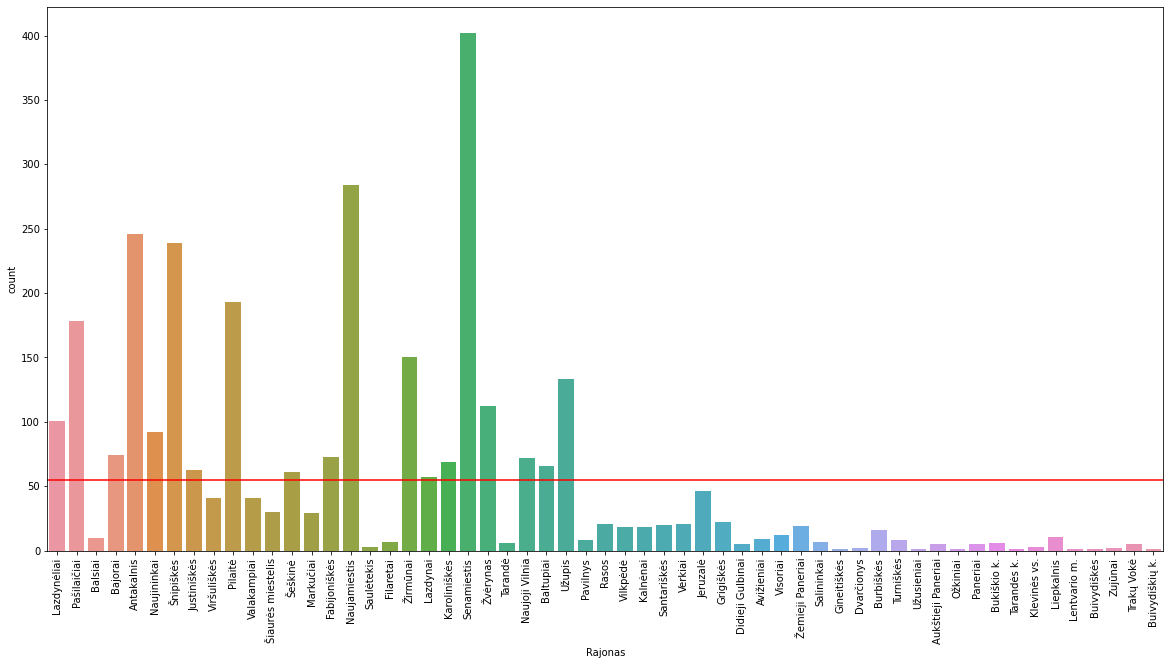

In [0]:
# Parduodamu butu kiekis rajonuose:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(x='Rajonas', data=df_p)
viduriukas=df_p[['Rajonas','Kaina']].groupby('Rajonas').count().mean()[0]
plt.axhline(viduriukas, c='red')

### KOMENTARAS:
# Raudona linija: vidurkis kiekviename rajone parduodamu butu.

Nors vizualizacija aiški, vis dėl to norėtūsi matyti visą sarašą populiarių ir nepopuliarių rajonų, bei jų skelbimų skaičių.

### Sarasas rajonų, kurių skelbimų skaičius yra didesnis nei vidurkis:

In [0]:
# Sarasas rajonu, kuriu skelbimu skaicius yra didesnis nei vidurkis:
top_rajonai=df_p[['Rajonas','Kaina']].groupby('Rajonas').count()
top_rajonai=top_rajonai[top_rajonai['Kaina']>viduriukas].sort_values('Kaina', ascending=False)
print('Is viso skelbimu: ', top_rajonai.sum()[0])
yy=df_p.groupby('Rajonas').mean().reset_index()
pd.merge(yy, top_rajonai, left_on='Rajonas', right_on='Rajonas').sort_values('Kaina_y', ascending=False)[['Rajonas','Kaina_x','Kaina_y']].rename(columns={'Kaina_y': 'Kiekis','Kaina_x':'Vidutinė Kaina'})

Is viso skelbimu:  2665


,Rajonas,Vidutinė Kaina,Kiekis
13,Senamiestis,224072.898010,402
8,Naujamiestis,137155.566901,284
0,Antakalnis,151908.203252,246
16,Šnipiškės,137025.799163,239
12,Pilaitė,95287.362694,193
11,Pašilaičiai,87829.623596,178
17,Žirmūnai,122648.433333,150
14,Užupis,171799.308271,133
18,Žvėrynas,195168.178571,112
7,Lazdynėliai,92747.584158,101


Top rajonuose iš beveik 3200 butų skelbimų, net 2665 yra populiariuosiuose rajonuose. O Top lyderis yra **Senamiestis**.
Kiti rajonai esantys sąrašo viršuje atsilieka 1,5-4 karto. Suprantama, jog šie rajonai yra populiarūs dėl puikios lokacijos ir susisiekimo su kitais rajonais.




In [0]:
# Sarasas rajonu, kuriu skelbimu skaicius yra didesnis nei vidurkis:
bot_rajonai=df_p[['Rajonas','Kaina']].groupby('Rajonas').count()
bot_rajonai=bot_rajonai[bot_rajonai['Kaina']<viduriukas].sort_values('Kaina', ascending=False)
print('Is viso skelbimu: ', bot_rajonai.sum()[0])
yy=df_p.groupby('Rajonas').mean().reset_index()
pd.merge(yy, bot_rajonai, left_on='Rajonas', right_on='Rajonas').sort_values('Kaina_y', ascending=False)[['Rajonas','Kaina_x','Kaina_y']].rename(columns={'Kaina_x':'Vidutinė Kaina','Kaina_y':'Kiekis'})

Is viso skelbimu:  463


,Rajonas,Vidutinė Kaina,Kiekis
12,Jeruzalė,111179.760870,46
30,Valakampiai,202152.658537,41
33,Viršuliškės,85180.487805,41
36,Šiaurės miestelis,138335.633333,30
17,Markučiai,128779.862069,29
11,Grigiškės,52770.363636,22
31,Verkiai,153674.761905,21
21,Rasos,105027.428571,21
23,Santariškės,128504.000000,20
37,Žemieji Paneriai,45625.421053,19


Nepopuliariuose rajonuose dominuoje užmiesčiuose esantys butai. Normalu, jog šiuolaikinis vilnietis nori būti veiksmo centre, o ne važiuoti valandą nuo namų iki Vilniaus širdies.

**Kitas paaiškinimas**: užmiestyje daugiau dominuoja gyvenamieji namai ir kotedžai, nei butai, todėl natūralu, kad užmiestyje esančių daugiabučių pasiūla bus maža.

**Idėja ateičiai**: pašalinti užmiestinius rajonus, kurie vis vien yra Vilniaus miesto dalis.


### Žinome, kad vieni rajonai yra populiaresni už kitus, tačiau kaip skiriasi butų rodikliai tarp tų rajonų?

Čia darome prielaidą, jog butai skelbimuose atspindi dabartinę esamą populiarumą, tuo tarpu registruotų žmonių kiekis atitinkamuose rajonuose atspindi nusistovėjusią populiarumo tendenciją.

Geriausiai dabartinį populiarumą galime įvertinti per paklausą/pasiūlą.

In [0]:
df_p_top=df_p.loc[df_p['Rajonas'].isin(top_rajonai.index)]
df_p_bot=df_p.loc[~df_p['Rajonas'].isin(top_rajonai.index)]

print('Vidutiniai butu rodikliai populiariuose rajonuose:')
print(df_p_top.mean())
print()
print('Vidutiniai butu rodikliai NEpopuliariuose rajonuose:')
print(df_p_bot.mean())
print()
print('Skirtumai tarp rajonu:')
print(df_p_top.mean()-df_p_bot.mean())

Vidutiniai butu rodikliai populiariuose rajonuose:
Kaina             134268.971107
Kambariai              2.507692
Plotas                63.151820
Aukstas                3.502439
Is viso aukstu         6.024015
dtype: float64

Vidutiniai butu rodikliai NEpopuliariuose rajonuose:
Kaina             110253.736501
Kambariai              2.546436
Plotas                65.020799
Aukstas                2.930886
Is viso aukstu         4.835853
dtype: float64

Skirtumai tarp rajonu:
Kaina             24015.234606
Kambariai            -0.038744
Plotas               -1.868979
Aukstas               0.571553
Is viso aukstu        1.188162
dtype: float64



Nepopuliariuose rajonuose vidutiniškai BEVEIK tokio paties dydžio buto (2,5 kambario tačiau ~2m² didesnio pločio) kaina vidutiniškai yra mažesnė 24k eurų.

### Kaip vizualiai skiriasi kainos tarp populiarių ir nepopuliarių rajonų?

In [0]:
kainu_skirtumai=df_p[['Rajonas','Kaina']]
kainu_skirtumai.loc[kainu_skirtumai['Rajonas'].isin(top_rajonai.index), 'Populiarumas'] = 'TOP'
kainu_skirtumai['Populiarumas']=kainu_skirtumai['Populiarumas'].fillna('BOT')

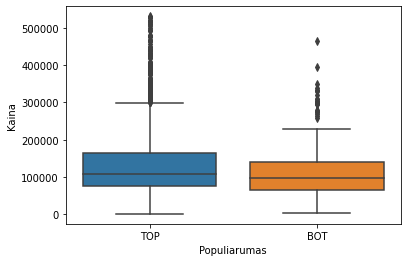

In [0]:
sns.boxplot(x='Populiarumas', y='Kaina', data=kainu_skirtumai)

O dabar pateikime tai skaičiais:

In [0]:
kainu_skirtumai[['Populiarumas','Kaina']].groupby('Populiarumas').describe()

Kaina                               ...                              
               count           mean           std  ...       50%       75%       max
Populiarumas                                       ...                              
BOT            463.0  110253.736501  68262.994334  ...   98000.0  139900.0  465000.0
TOP           2665.0  134268.971107  89969.749815  ...  107000.0  165000.0  531875.0

[2 rows x 8 columns]

Iš šios analizės galime matyti, kad kainos atžvilgiu, tarp rajonų didelio skirtumo nėra:

**Panašumai**
*   Abiejuose rajonuose yra daugiabučio tipo butų - tai galime sakyti iš itin žemos kainos (~10k)
*   Mediana yra panaši - skiriasi per 9 000 eur.
*   Abiejuose rajonuose yra prabangių butų kurių kaina siekia pusę milijono.

**Skirtumai**

*   Didžioji skelbimų dalis skiriasi: populiarių rajonų kainos režiai yra 76-165k, tuo tarpu nepopuliariuose - 65-140k. Galime teigti, bendrai, apimant visus skelbimus, populariuose rajonuose tenka permokėti 11-25k.
*   Butų kainos vidurkis skiriasi per 24k eurų, tačiau tai itin susiję su kitu skirtumu
*   Jog skelbimų populiariuose rajonuose yra ~6 kartais daugiau






### Bendras vaizdas: butų kainos pasiskirstymas tarp visų rajonų:

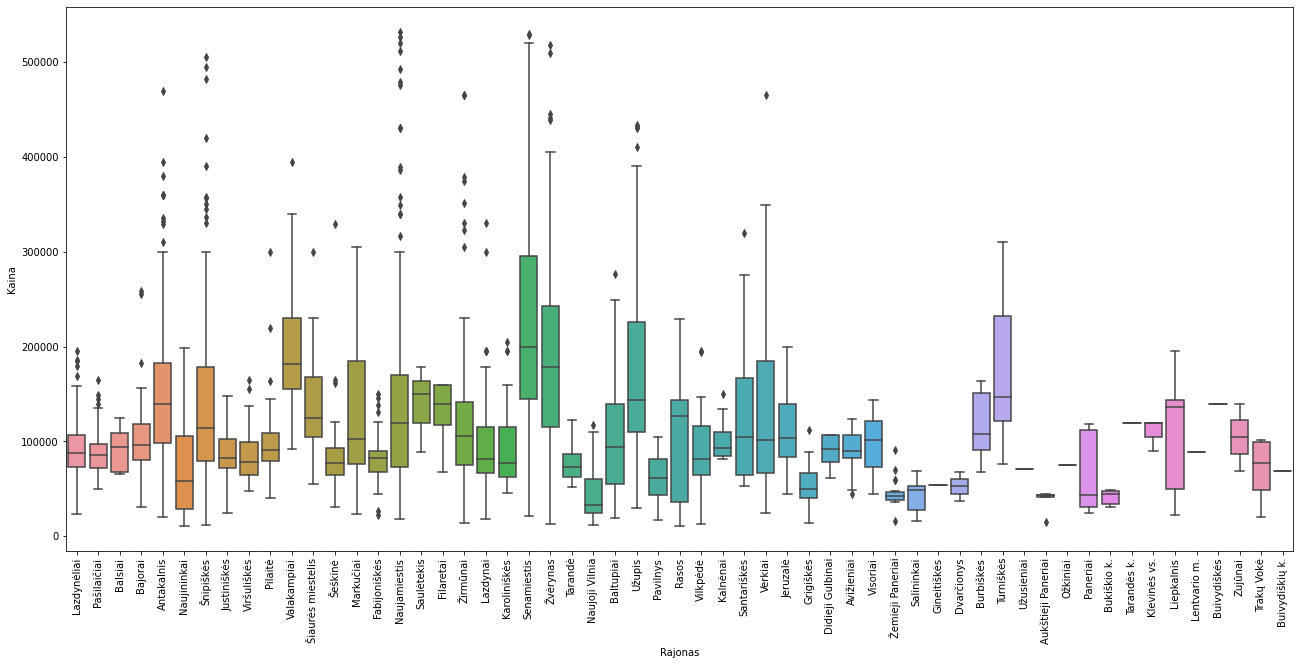

In [0]:
plt.figure(figsize=(22, 10))
plt.xticks(rotation=90)
sns.boxplot(df_p['Rajonas'], df_p['Kaina'])

## 2.2 Su Vilniuje registruotų žmonių duomenimis:

### Registruotų gyventojų skaičius rajonuose:

Panagrinėjus būstų kainas, galime matyti kad tiek populiariuose, tiek nepopuliariuose rajonuose kainos yra panašios už tokio paties būto rodiklius. Todėl bandome išsiaiškinti kaip kainas įtakoja žmonių pasiskirstymas rajonuose.

In [0]:
rajonai=df_zmones[['SENIUNIJA','GATVE']].groupby('SENIUNIJA').count().reset_index().sort_values('GATVE', ascending=False)
rajonai=rajonai.rename(columns={'GATVE':'Gyventojų skaičius'})
rajonai_daug=rajonai.loc[rajonai['Gyventojų skaičius']>rajonai['Gyventojų skaičius'].mean()]
rajonai_mazai=rajonai.loc[rajonai['Gyventojų skaičius']<rajonai['Gyventojų skaičius'].mean()]

rajonai_kaina=df_p[['Kaina','Rajonas']]
rajonai_kaina.loc[rajonai_kaina['Rajonas'].isin(rajonai_daug['SENIUNIJA'].tolist()), 'Gyventoju kiekis'] = 'Daug'
rajonai_kaina['Gyventoju kiekis']=rajonai_kaina['Gyventoju kiekis'].fillna('Mažai')

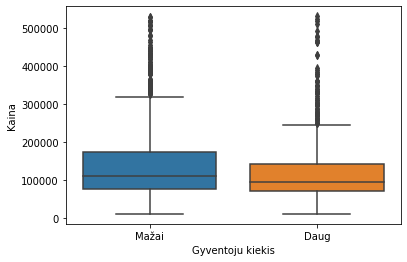

In [0]:
sns.boxplot(x='Gyventoju kiekis', y='Kaina', data=rajonai_kaina)

In [0]:
rajonai_kaina[['Gyventoju kiekis','Kaina']].groupby('Gyventoju kiekis').describe()

Kaina                 ...                    
                   count           mean  ...       75%       max
Gyventoju kiekis                         ...                    
Daug              1162.0  117565.341652  ...  142000.0  531875.0
Mažai             1966.0  138485.941506  ...  175000.0  530000.0

[2 rows x 8 columns]

Kaip ir galima tikėtis, rajonuose, kur yra mažiau registruotų gyventojų, butų kaina yra didesnė: Vilniečiai vertina erdvę ir nori jog joje nebūtų sausakimša žmonių.

### Rajonų kainos pagal vyriausius ir seniausius jos gyventojus.

In [0]:
#### Zmoniu amzius rajonuose:
print('Jaunesi zmones gyvena siuose rajonuose: ')
jauniausi=df_zmones_ramzius.loc[df_zmones_ramzius['GIMIMO_METAI'] > df_zmones_ramzius.mean()[0]].sort_values('GIMIMO_METAI', ascending=False)
print(jauniausi)

print()
print('Vyriausi zmones gyvena siuose rajonuose: ')
vyriausi=df_zmones_ramzius.loc[df_zmones_ramzius['GIMIMO_METAI'] < df_zmones_ramzius.mean()[0]].sort_values('GIMIMO_METAI', ascending=False)
print(vyriausi)

Jaunesi zmones gyvena siuose rajonuose: 
          SENIUNIJA  GIMIMO_METAI
11          Pilaitė   1983.857032
10      Pašilaičiai   1983.298610
14          Verkiai   1981.961792
20         Žvėrynas   1980.676330
13      Senamiestis   1980.067662
9          Paneriai   1979.903967
6      Naujamiestis   1979.499176
8   Naujoji  Vilnia   1979.306285
1      Fabijoniškės   1979.068036
12            Rasos   1978.779927
0        Antakalnis   1978.488229

Vyriausi zmones gyvena siuose rajonuose: 
       SENIUNIJA  GIMIMO_METAI
18     Šnipiškės   1977.436839
2      Grigiškės   1977.185287
7    Naujininkai   1977.013880
5       Lazdynai   1976.617538
3    Justiniškės   1976.239342
19      Žirmūnai   1975.742953
15      Vilkpėdė   1975.141642
16   Viršuliškės   1974.770873
17       Šeškinė   1974.742458
4   Karoliniškės   1973.254760


Kai turime rajonus su vyriausiais ir seniausiais gyventojais, pažiūrėkime, kaip skirasi kainos. Pagal idėją, rajonuose, kur žmonės yra jauniausi, kainos butų kainos turėtų būti didžiausios.

In [0]:
# pasidarome sarašą rajonų kur yra jauniausi ir seniausi gyventojai kad galėtume atsifiltruoti butus.
v_sarasas=vyriausi['SENIUNIJA'].tolist()
j_sarasas=jauniausi['SENIUNIJA'].tolist()

kainu_skirtumai_amzius=df_p[['Rajonas','Kaina']]
kainu_skirtumai_amzius.loc[kainu_skirtumai['Rajonas'].isin(v_sarasas), 'Gyventojai'] = 'Vyriausi'
kainu_skirtumai_amzius['Gyventojai']=kainu_skirtumai_amzius['Gyventojai'].fillna('Jauniausi')

Vizualus kainu pasiskirstymas:

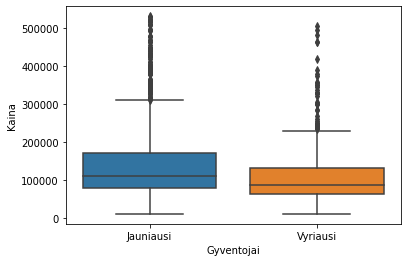

In [0]:
sns.boxplot(x='Gyventojai', y='Kaina', data=kainu_skirtumai_amzius)

In [0]:
kainu_skirtumai_amzius[['Gyventojai','Kaina']].groupby('Gyventojai').describe()

Kaina                               ...                               
             count           mean           std  ...       50%        75%       max
Gyventojai                                       ...                               
Jauniausi   2316.0  139371.112263  91342.589399  ...  112000.0  172000.00  531875.0
Vyriausi     812.0  106023.142857  69881.994455  ...   87950.0  130916.25  504906.0

[2 rows x 8 columns]

Kaip ir buvo galima tikėtis: rajonai, kuriuose gyvena jaunesni žmonės yra populiaresni - skelbimų yra ~3 daugiau.



**Panašumai**
*   Abiejuose rajonuose yra daugiabučio tipo butų - tai galime sakyti iš itin žemos kainos (~10k)
*   Mediana itin ryškiai skiriasi: jaunesnių žmonių rajonuose daugiausia būtų yra apie 112k eurų ribą, tuo tarpu pas vyresnius - 88k.
*   Abiejuose rajonuose yra prabangių butų kurių kaina siekia pusę milijono.

**Skirtumai**

*   Kad gyventume su jaunesniais Vilniaus gyventojais,  vidutiniškai turime permokėti 34k.
*   Permokėjimo rėžiai: jaunesnių žmonių rajonuose kainos režiai yra 111-172k, tuo tarpu vyresnių - 109-131k. Galime teigti, bendrai, apimant visus skelbimus, kad gyvenimas tarp jaunų žmonių mums papildomai kainuoja 2-41k eurų.

### Ar populiarūs rajonai yra tie patys, kuriuose gyvena jaunesni žmonės?

In [0]:
# sudarome bendrą lentelę su populiariais rajonais ir amžiumi.
kainu_skirtumai_bendras=kainu_skirtumai
kainu_skirtumai_bendras.loc[kainu_skirtumai_bendras['Rajonas'].isin(v_sarasas), 'Gyventojai'] = 'Vyriausi'
kainu_skirtumai_bendras['Gyventojai']=kainu_skirtumai_bendras['Gyventojai'].fillna('Jauniausi')

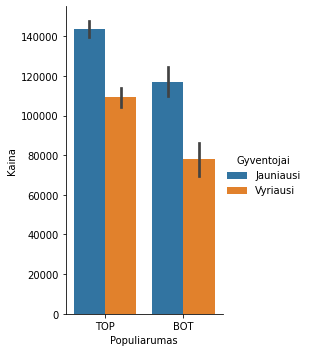

In [0]:
sns.catplot(y='Kaina', x="Populiarumas", hue="Gyventojai", data=kainu_skirtumai_bendras, kind='bar', height=5, aspect=.7)

Galime matyti, jog jaunesnių žmonių, vis dėl to yra daugiau populiariuose rajonuose, nei nepopuliariuose, bei tai:



*   Jei norime gyventi tarp **jaunesnių gyventojų** ir **populiariame rajone**: vidutiniškai mokėsime **143k** už būtą.
*   Jei norime gyventi tarp **jaunesnių gyventojų** bet **ne populiariame rajone**: vidutiniškai mokėsime **117k** už butą.



*   Jei norime gyventi tarp **vyresnių gyventojų** ir **populiariame rajone**: vidutiniškai mokėsime **109** už būtą.
*   Jei norime gyventi tarp **vyresnių gyventojų** bet **ne populiariame rajone**: vidutiniškai mokėsime **78k** už butą.







In [0]:
kainu_skirtumai_bendras[['Populiarumas', 'Gyventojai', 'Kaina']].groupby(['Populiarumas', 'Gyventojai']).describe()

Kaina                 ...                    
                          count           mean  ...       75%       max
Populiarumas Gyventojai                         ...                    
BOT          Jauniausi    382.0  117105.850785  ...  144000.0  465000.0
             Vyriausi      81.0   77938.827160  ...   89000.0  195000.0
TOP          Jauniausi   1934.0  143768.904343  ...  180000.0  531875.0
             Vyriausi     731.0  109135.084815  ...  135000.0  504906.0

[4 rows x 8 columns]

### Popliarūs rajonai, žmonių kiekis ir jų amžius

In [0]:
kainu_skirtumai_bendras=pd.concat([kainu_skirtumai_bendras,rajonai_kaina['Gyventoju kiekis']], axis=1)
kainu_skirtumai_bendras

,Rajonas,Kaina,Populiarumas,Gyventojai,Gyventoju kiekis
0,Lazdynėliai,69070,TOP,Jauniausi,Mažai
1,Pašilaičiai,74200,TOP,Jauniausi,Daug
2,Balsiai,99000,BOT,Jauniausi,Mažai
3,Bajorai,108800,TOP,Jauniausi,Mažai
4,Antakalnis,155000,TOP,Jauniausi,Daug
...,...,...,...,...,...
3199,Naujamiestis,57000,TOP,Jauniausi,Daug
3200,Senamiestis,304000,TOP,Jauniausi,Mažai
3201,Naujininkai,15308,TOP,Vyriausi,Daug
3202,Fabijoniškės,47787,TOP,Jauniausi,Daug


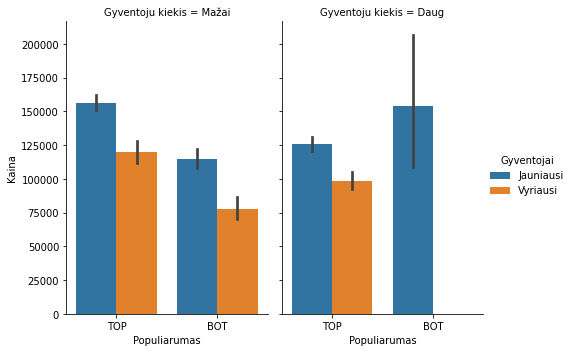

In [0]:
sns.catplot(y='Kaina', x="Populiarumas", hue="Gyventojai", col='Gyventoju kiekis', data=qwewer, kind='bar', height=5, aspect=.7)

In [0]:
kainu_skirtumai_bendras[['Populiarumas', 'Gyventojai', 'Kaina','Gyventoju kiekis']].groupby(['Populiarumas', 'Gyventojai','Gyventoju kiekis']).describe()

Kaina  ...          
                                           count  ...       max
Populiarumas Gyventojai Gyventoju kiekis          ...          
BOT          Jauniausi  Daug                21.0  ...  465000.0
                        Mažai              361.0  ...  395000.0
             Vyriausi   Mažai               81.0  ...  195000.0
TOP          Jauniausi  Daug               781.0  ...  531875.0
                        Mažai             1153.0  ...  530000.0
             Vyriausi   Daug               360.0  ...  465000.0
                        Mažai              371.0  ...  504906.0

[7 rows x 8 columns]

### Lyties pasiskirstymas Vilniuje

Registruotų moterų gyvenančių Vilniuje yra 313k, tuo tarpu vyrų - 269k.

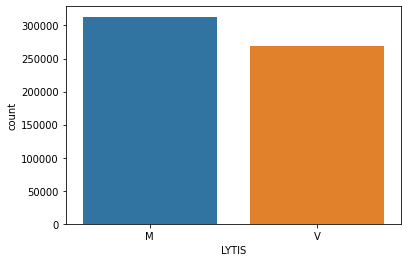

In [0]:
sns.countplot(x='LYTIS', data=df_zmones_pilnas)

In [0]:
df_zmones_pilnas.groupby('LYTIS').count()

,GIMIMO_METAI,SEIMOS_PADETIS,KIEK_TURI_VAIKU,SENIUNIJA,GATVE
LYTIS,,,,,
M,313231,313231,313231,310050,310050
V,269296,269296,269296,265432,265432


### Lyties pasiskirstymas pagal rajonus

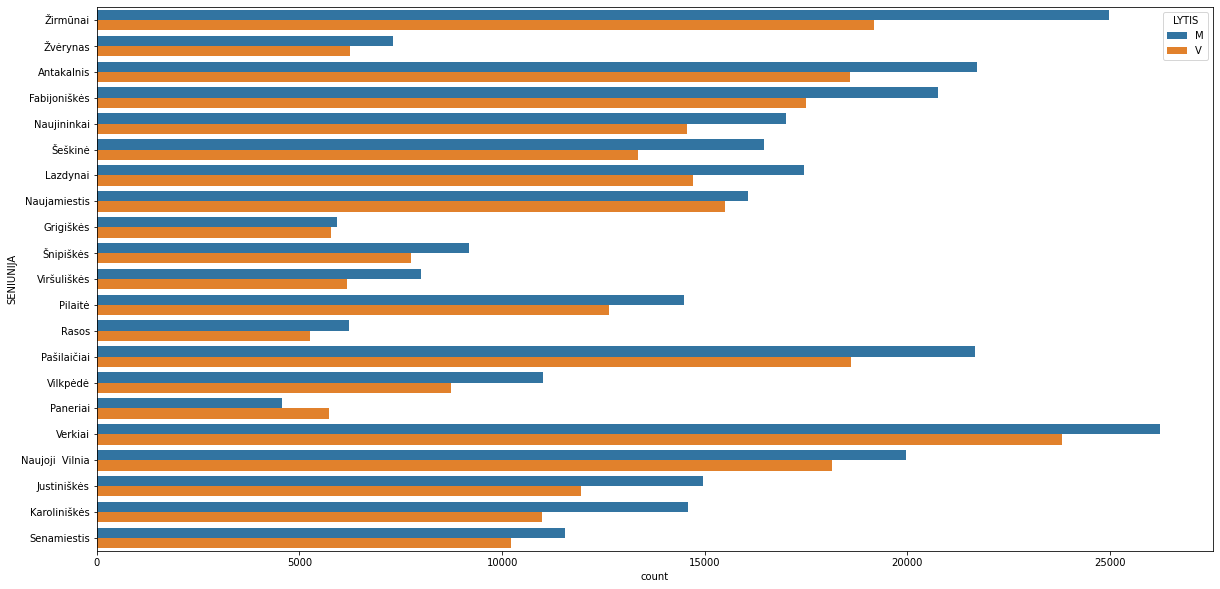

In [0]:
plt.figure(figsize=(20,10))
ax = sns.countplot(y='SENIUNIJA', hue='LYTIS', data=df_zmones_pilnas)

Matome, kad tik viename rajone yra daugiau vyrų nei moterų ir tai yra **Paneriai**.

In [0]:
moterys=df_zmones[['LYTIS_M','SENIUNIJA','VEDE']].loc[df_zmones['LYTIS_M']==1].groupby(['LYTIS_M','SENIUNIJA']).count().reset_index()
moterys=moterys[['SENIUNIJA','VEDE']]
moterys=moterys.rename(columns=({'VEDE':'Moterys'}))
vyrai=df_zmones[['LYTIS_V','SENIUNIJA','VEDE']].loc[df_zmones['LYTIS_V']==1].groupby(['LYTIS_V','SENIUNIJA']).count().reset_index()
vyrai=vyrai[['SENIUNIJA','VEDE']]
vyrai=vyrai.rename(columns=({'VEDE':'Vyrai'}))
#Sujungiame lenteles
df_zmones_lytis=pd.merge(vyrai,moterys,on='SENIUNIJA')

df_zmones_lytis.loc[df_zmones_lytis['Vyrai']>df_zmones_lytis['Moterys']]

,SENIUNIJA,Vyrai,Moterys
9,Paneriai,5733,4576


### Gyventoju seimynine padetis vilniaus rajonuose, pagal lyti

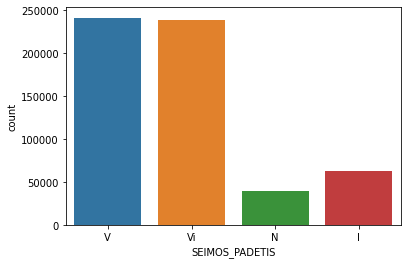

In [0]:
sns.countplot(x='SEIMOS_PADETIS', data=df_zmones_pilnas)

In [0]:
df_zmones_pilnas[['SEIMOS_PADETIS','LYTIS']].groupby('SEIMOS_PADETIS').count()

,LYTIS
SEIMOS_PADETIS,
I,63249
N,38913
V,241216
Vi,239149


Matome,jog daugiausia vilniuje vienišų ir santuokoje esančių žmonių. Tuo tarpu išsiskyrusių yra 63k, o našlių - 38K

Žmonių pasiskirstymas per rajonus:

<Figure size 1440x720 with 0 Axes>

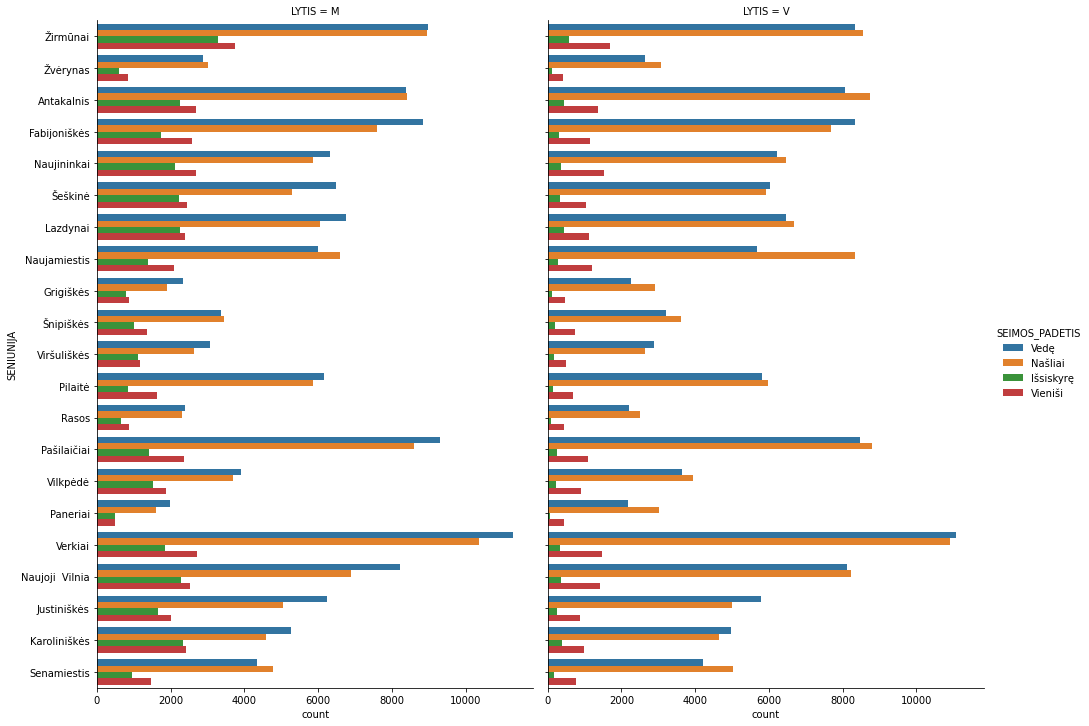

In [0]:
plt.figure(figsize=(20,10))
g = sns.catplot(y='SENIUNIJA', hue='SEIMOS_PADETIS', col='LYTIS', data=df_zmones_pilnas, kind='count', height=10, aspect=.7);

# Pakeiciamos legendos reiksmes
new_labels = ['Vedę', 'Našliai', 'Išsiskyrę','Vieniši']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

### Sprendimas vienišiems žmonėms: kur gyvena daugiausia vienišų moterų ir vyrų?

In [0]:
df_vienisi_zmones=df_zmones_pilnas.loc[df_zmones_pilnas['SEIMOS_PADETIS']=='Vi']
df_vienisi_zmones=pd.get_dummies(df_vienisi_zmones, columns=['LYTIS'])


vienisos_moterys=df_vienisi_zmones[['LYTIS_M','SENIUNIJA','GATVE']].loc[df_vienisi_zmones['LYTIS_M']==1].groupby(['LYTIS_M','SENIUNIJA']).count().reset_index()
vienisos_moterys=vienisos_moterys[['SENIUNIJA','GATVE']]
vienisos_moterys=vienisos_moterys.rename(columns=({'GATVE':'Moterys'}))

vienisi_vyrai=df_vienisi_zmones[['LYTIS_V','SENIUNIJA','GATVE']].loc[df_vienisi_zmones['LYTIS_V']==1].groupby(['LYTIS_V','SENIUNIJA']).count().reset_index()
vienisi_vyrai=vienisi_vyrai[['SENIUNIJA','GATVE']]
vienisi_vyrai=vienisi_vyrai.rename(columns=({'GATVE':'Vyrai'}))

#Sujungiame lenteles
vienisi_zmones_lytis=pd.merge(vienisi_vyrai,vienisos_moterys,on='SENIUNIJA')

Jeigu norime gyventi rajonuose kur yra daugiau vienišų moterų, reikėtų rinktis šiuos rajonus:

In [0]:
xmoterys=vienisi_zmones_lytis.loc[vienisi_zmones_lytis['Vyrai']<vienisi_zmones_lytis['Moterys']]
yy=df_p.groupby('Rajonas').mean().reset_index()
pd.merge(yy, xmoterys, left_on='Rajonas', right_on='SENIUNIJA').drop(['Vyrai'], axis=1).sort_values('Moterys', ascending=False)

,Rajonas,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,SENIUNIJA,Moterys
2,Žirmūnai,122648.433333,2.366667,58.752867,4.446667,7.333333,Žirmūnai,8962
0,Justiniškės,87032.015873,2.492063,57.628254,3.365079,6.111111,Justiniškės,5044
1,Viršuliškės,85180.487805,2.365854,52.578049,6.390244,11.731707,Viršuliškės,2641


Jeigu norime gyventi rajonuose kur yra daugiau vienišų vyrų, reikėtų rinktis šiuos rajonus:

In [0]:
xvyrai=vienisi_zmones_lytis.loc[vienisi_zmones_lytis['Vyrai']>vienisi_zmones_lytis['Moterys']]
yy=df_p.groupby('Rajonas').mean().reset_index()
pd.merge(yy, xvyrai, left_on='Rajonas', right_on='SENIUNIJA').drop(['Moterys'], axis=1).sort_values('Vyrai', ascending=False)

,Rajonas,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,SENIUNIJA,Vyrai
12,Verkiai,153674.761905,2.619048,70.894762,3.809524,5.571429,Verkiai,10913
8,Pašilaičiai,87829.623596,2.410112,58.724101,5.067416,7.915730,Pašilaičiai,8788
0,Antakalnis,151908.203252,2.772358,72.605041,2.772358,4.760163,Antakalnis,8732
5,Naujamiestis,137155.566901,2.299296,58.069120,3.408451,6.218310,Naujamiestis,8344
1,Fabijoniškės,82503.684932,2.657534,63.540137,5.671233,9.191781,Fabijoniškės,7695
4,Lazdynai,96895.491228,2.491228,60.180702,3.701754,5.964912,Lazdynai,6673
6,Naujininkai,67827.771739,2.152174,49.326196,2.597826,4.010870,Naujininkai,6456
9,Pilaitė,95287.362694,2.632124,61.329223,3.264249,5.626943,Pilaitė,5967
14,Šeškinė,85987.754098,2.114754,50.815246,3.819672,7.459016,Šeškinė,5931
11,Senamiestis,224072.898010,2.820896,78.703458,2.905473,4.353234,Senamiestis,5038


### Interaktyvus sprendimas: rask partnerį su +- 3 metų skirtumu ir sužinok kiek vidutiniškai tame rajone kainuoja tavo butas!

In [0]:
x=int(input('Įveskite savo amžių: '))
y=input('Lytis: ')
xx=2020-x
tinder=df_zmones_pilnas.loc[(df_zmones_pilnas['GIMIMO_METAI']>xx-3)&(df_zmones_pilnas['GIMIMO_METAI']<xx+3)&(df_zmones_pilnas['LYTIS']!=y)&(df_zmones_pilnas['SEIMOS_PADETIS']=='Vi')]
tinder=tinder[['SENIUNIJA','LYTIS']].groupby('SENIUNIJA').count().sort_values('LYTIS', ascending=False)
yy=df_p.groupby('Rajonas').mean().reset_index()
pd.merge(yy, tinder, left_on='Rajonas', right_on='SENIUNIJA').sort_values('LYTIS', ascending=False)

Įveskite savo amžių: 25
Lytis: V


,Rajonas,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,LYTIS
13,Verkiai,153674.761905,2.619048,70.894762,3.809524,5.571429,1003
0,Antakalnis,151908.203252,2.772358,72.605041,2.772358,4.760163,857
18,Žirmūnai,122648.433333,2.366667,58.752867,4.446667,7.333333,826
9,Pašilaičiai,87829.623596,2.410112,58.724101,5.067416,7.915730,678
1,Fabijoniškės,82503.684932,2.657534,63.540137,5.671233,9.191781,652
7,Naujininkai,67827.771739,2.152174,49.326196,2.597826,4.010870,618
6,Naujamiestis,137155.566901,2.299296,58.069120,3.408451,6.218310,606
5,Lazdynai,96895.491228,2.491228,60.180702,3.701754,5.964912,575
10,Pilaitė,95287.362694,2.632124,61.329223,3.264249,5.626943,547
16,Šeškinė,85987.754098,2.114754,50.815246,3.819672,7.459016,483


# 3. Duomenų prognozavimas naudojant regresinius modelius

Modeliams naudosime bendra lentelė iš visų turimų duomenų kuri yra apdirbta ir paruošta naudojimui.

**Svarbu:** Visi duomenys tarpusavį yra apjungti per Gatves.

In [0]:
df_bendras

,Rajonas,Gatve,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,bendr_plotas,naud_plotas,butu_skaicius,negyvenamuju_palapu_skaicius,renov_skaicius,vid_statybos_m,KIEK_TURI_VAIKU,LYTIS_M,LYTIS_V,ISSISKYRE,NASLYS,VEDE,VIENISI,VID. GIM. METAI
0,Lazdynėliai,Bukčių g.,69070,2,40.46,2,5,19262.04,13889.05,218.0,65.0,1.0,1984.071429,242.0,351.0,292.0,65.0,44.0,275.0,259.0,1979.096423
1,Bajorai,Bajorų kel.,108800,4,69.51,2,6,52430.86,42278.57,807.0,196.0,0.0,2011.571429,964.0,852.0,824.0,119.0,29.0,767.0,761.0,1989.532220
2,Antakalnis,Vytauto Žalakevičiaus g.,155000,2,63.11,3,7,1532.72,1477.66,321.0,22.0,0.0,1844.666667,523.0,568.0,483.0,85.0,25.0,433.0,508.0,1987.727878
3,Naujininkai,Panevėžio g.,84500,2,54.00,3,4,16666.12,14022.80,287.0,30.0,0.0,1959.866667,183.0,388.0,319.0,118.0,39.0,261.0,289.0,1975.446959
4,Šnipiškės,Giedraičių g.,95000,2,53.61,8,10,17575.68,15816.21,286.0,9.0,0.0,1945.285714,335.0,613.0,530.0,173.0,85.0,377.0,508.0,1977.165354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,Naujamiestis,Savanorių pr.,57000,3,56.82,2,5,164755.20,134815.23,2684.0,117.0,1.0,1926.326923,1907.0,3615.0,2803.0,846.0,636.0,2463.0,2473.0,1975.644593
2707,Senamiestis,Gaono g.,304000,2,115.72,2,3,4175.75,2674.42,25.0,8.0,0.0,1940.000000,7.0,14.0,9.0,2.0,1.0,11.0,9.0,1974.130435
2708,Naujininkai,Naugarduko g.,15308,1,25.89,1,1,65569.51,50852.85,1067.0,89.0,0.0,1948.931818,570.0,1124.0,948.0,320.0,172.0,725.0,855.0,1975.396718
2709,Fabijoniškės,S. Stanevičiaus g.,47787,3,67.00,5,5,265254.25,228440.05,4184.0,129.0,3.0,1988.927536,2892.0,5315.0,4350.0,1017.0,604.0,4428.0,3616.0,1975.863632


In [0]:
df_bendras.corr()

,Kaina,Kambariai,Plotas,Aukstas,Is viso aukstu,bendr_plotas,naud_plotas,butu_skaicius,negyvenamuju_palapu_skaicius,renov_skaicius,vid_statybos_m,KIEK_TURI_VAIKU,LYTIS_M,LYTIS_V,ISSISKYRE,NASLYS,VEDE,VIENISI,VID. GIM. METAI
Kaina,1.000000,0.586022,0.744361,0.099518,0.059685,-0.221242,-0.234289,-0.234806,-0.091721,-0.088060,-0.016522,-0.248630,-0.250134,-0.251750,-0.252514,-0.236527,-0.250827,-0.249326,0.129434
Kambariai,0.586022,1.000000,0.818758,0.007024,-0.020603,-0.071210,-0.072547,-0.080612,-0.036003,-0.029599,-0.023030,-0.062520,-0.069709,-0.067900,-0.081767,-0.076749,-0.062517,-0.068627,0.039904
Plotas,0.744361,0.818758,1.000000,0.053865,0.011939,-0.112591,-0.118035,-0.127407,-0.031547,-0.050533,0.004503,-0.111386,-0.122076,-0.119352,-0.132439,-0.127071,-0.116222,-0.118557,0.058415
Aukstas,0.099518,0.007024,0.053865,1.000000,0.733786,0.105095,0.105425,0.090660,0.137490,0.023268,0.054049,0.136967,0.104593,0.110656,0.094133,0.075734,0.108338,0.116224,0.058873
Is viso aukstu,0.059685,-0.020603,0.011939,0.733786,1.000000,0.094710,0.099016,0.081914,0.078890,0.028813,0.046791,0.122876,0.095897,0.100419,0.084543,0.074404,0.100699,0.103171,0.054429
bendr_plotas,-0.221242,-0.071210,-0.112591,0.105095,0.094710,1.000000,0.996133,0.991364,0.530746,0.704377,0.052973,0.925539,0.964182,0.960926,0.964294,0.950410,0.951852,0.960041,-0.365625
naud_plotas,-0.234289,-0.072547,-0.118035,0.105425,0.099016,0.996133,1.000000,0.991507,0.495331,0.692238,0.053227,0.926934,0.968644,0.964938,0.966529,0.956135,0.958850,0.961491,-0.378171
butu_skaicius,-0.234806,-0.080612,-0.127407,0.090660,0.081914,0.991364,0.991507,1.000000,0.490432,0.737544,0.049233,0.908882,0.963869,0.955400,0.972872,0.970983,0.945513,0.952238,-0.397363
negyvenamuju_palapu_skaicius,-0.091721,-0.036003,-0.031547,0.137490,0.078890,0.530746,0.495331,0.490432,1.000000,0.342724,0.058209,0.517658,0.428584,0.439449,0.408984,0.362567,0.418567,0.467516,0.121462
renov_skaicius,-0.088060,-0.029599,-0.050533,0.023268,0.028813,0.704377,0.692238,0.737544,0.342724,1.000000,0.023806,0.602504,0.674876,0.653500,0.695734,0.734863,0.636394,0.658757,-0.325909


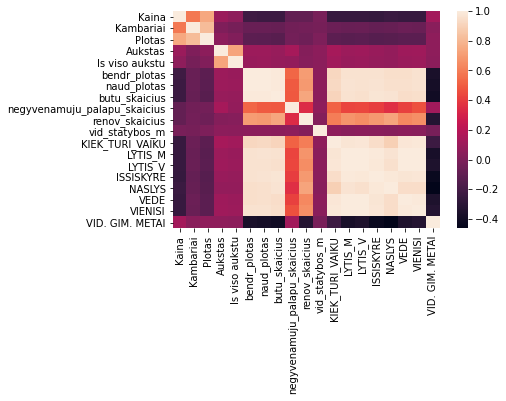

In [0]:
sns.heatmap(df_bendras.corr())

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## 3.1 Tiesinis regresijos modelis 

Pirmiausia testuosime paprastą tiesinį regresinį modelį, tačiau neįtrauksime Gatvių ir Rajonų, kaip reikšmių.

Nesirenkame įtraukti gatvių, nes tuomet yra tiesiog per daug kintamųjų.

Accuracy of the model: 0.6093509250702742
MAE:  37790.51483810916
MedAE:  26945.995844664518
R^2:  0.6093509250702742
Mean Squared Error:  3161818226.81206


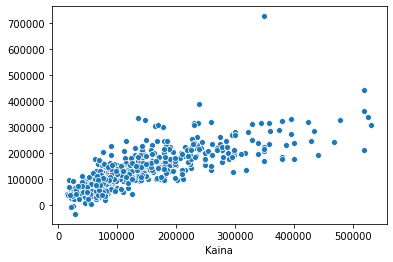

In [0]:
######## REGRESINIS MODELIS 1 ########
# Be rajonu
model1=LinearRegression()
x1=df_bendras.drop(['Kaina','Gatve','Rajonas'], axis=1)
y1=df_bendras['Kaina']

x0_train, x0_test, y0_train, y0_test = train_test_split(x1,y1, random_state=33)
model1.fit(x0_train, y0_train)
y0_pred = model1.predict(x0_test)

#Modelio tikrinimas vizualiai:
sns.scatterplot(y0_test,y0_pred)

# koks yra modelio nuokrypis tarp test ir predict duomenu.

print('Accuracy of the model: ' + str(model1.score(x0_test,y0_test)))
print('MAE: ', mean_absolute_error(y0_test, y0_pred))
print('MedAE: ', median_absolute_error(y0_test, y0_pred))
print('R^2: ', r2_score(y0_test, y0_pred))
print('Mean Squared Error: ', mean_squared_error(y0_test, y0_pred))

## 3.2 Tiesinis regresijos modelis naudojant sukategorizuotus rajonus

Įdedame ir sukategorizuotus rajonus, nes akivaizdu, kad rajonas daro reikšmę buto kainai.

Accuracy of the model: 0.7252656894799343
MAE:  30086.344112242357
MedAE:  19610.250341851497
R^2:  0.7252656894799343
Mean Squared Error:  2223632426.8507533


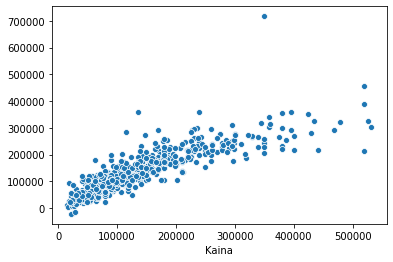

In [0]:
df_bendras_m2=pd.get_dummies(df_bendras, columns=['Rajonas'])
model2=LinearRegression()
x2=df_bendras_m2.drop(['Kaina','Gatve'], axis=1)
y2=df_bendras_m2['Kaina']

x_train, x_test, y_train, y_test = train_test_split(x2,y2, random_state=33)
model2.fit(x_train, y_train)
y2_pred = model2.predict(x_test)

#Modelio tikrinimas vizualiai:
sns.scatterplot(y_test,y2_pred)

print('Accuracy of the model: ' + str(model2.score(x_test,y_test)))
print('MAE: ', mean_absolute_error(y_test, y2_pred))
print('MedAE: ', median_absolute_error(y_test, y2_pred))
print('R^2: ', r2_score(y_test, y2_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y2_pred))

## 3.3 Gradient Modelis

Accuracy of the model: 0.8335048012215979
MAE:  21371.169645949205
MedAE:  10588.483758956041
R^2:  0.8335048012215979
Mean Squared Error:  1347571485.4027197


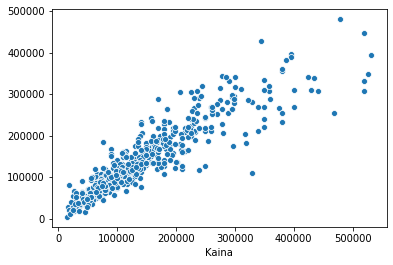

In [0]:
################ REGRESINIS MODELIS 3 : GRADIENT MODEL 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn import ensemble
# x3=df_bendras_m2.drop(['Kaina','Gatve'], axis=1)
# y3=df_bendras_m2['Kaina']
# x_train, x_test, y_train, y_test = train_test_split(x2,y2, random_state=33)

model3=ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')
model3.fit(x_train, y_train)
y3_pred = model3.predict(x_test)
sns.scatterplot(y_test,y3_pred)

print('Accuracy of the model: ' + str(model3.score(x_test,y_test)))
print('MAE: ', mean_absolute_error(y_test, y3_pred))
print('MedAE: ', median_absolute_error(y_test, y3_pred))
print('R^2: ', r2_score(y_test, y3_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y3_pred))

## 3.4 Ensemble Learning — Random Forest Regressor

In [0]:
### REGRESINIS MODELIS 4 : Ensemble Learning — Random Forest Regressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, x_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)

# find root mean squared error, scores is an array of negative numbers
rmse_scores = np.sqrt(-scores)

print("Mean:\t\t ", rmse_scores.mean(), "\nStandard Deviation:", rmse_scores.std())

Mean:		  47950.352224854716 
Standard Deviation: 4564.249876609716


In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, x_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)

# find root mean squared error
rmse_scores = np.sqrt(-scores)

print("Mean:\t\t ", rmse_scores.mean(), "\nStandard Deviation:", rmse_scores.std())

Mean:		  56230.22107162336 
Standard Deviation: 4362.7849125193425


In [0]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(x_train, y_train)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
forest_scores = cross_val_score(forest_reg, x_train, y_train,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("Mean:\t\t ", forest_rmse_scores.mean(), "\nStandard Deviation:", forest_rmse_scores.std())

Mean:		  39074.80235145347 
Standard Deviation: 5378.401295785784


In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [0]:
cvres = grid_search.cv_results_
print("{}\t\t {}\n".format('Mean Score','Parameters'))
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    x = np.sqrt(-mean_score)
    y = params
    print("{:.2f}\t {}".format(x, y))

Mean Score		 Parameters

51573.57	 {'max_features': 2, 'n_estimators': 3}
48339.56	 {'max_features': 2, 'n_estimators': 10}
45194.80	 {'max_features': 2, 'n_estimators': 30}
51193.28	 {'max_features': 4, 'n_estimators': 3}
43443.18	 {'max_features': 4, 'n_estimators': 10}
43205.99	 {'max_features': 4, 'n_estimators': 30}
49173.54	 {'max_features': 6, 'n_estimators': 3}
44502.73	 {'max_features': 6, 'n_estimators': 10}
42060.84	 {'max_features': 6, 'n_estimators': 30}
49359.36	 {'max_features': 8, 'n_estimators': 3}
42060.81	 {'max_features': 8, 'n_estimators': 10}
41219.94	 {'max_features': 8, 'n_estimators': 30}
51651.65	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
45267.47	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
51394.97	 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
44781.04	 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
49920.21	 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
43615.15	 {'bootstrap': False, '

Model details:
Accuracy of the model: 0.7964205349386962
MAE:  23874.860703367143
MedAE:  12155.299999999996
R^2:  0.7964205349386962
Mean Squared Error:  1647722481.7472603


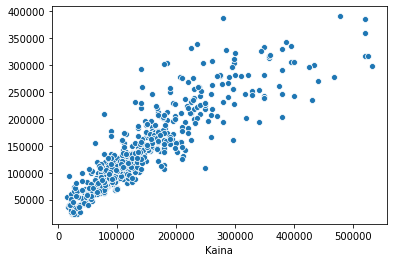

In [0]:
model4= grid_search.best_estimator_ # tinkamiausio modelio pasirinkimas: {'max_features': 8, 'n_estimators': 30}
y4_pred = model4.predict(x_test)
# find mean square error
final_mse = mean_squared_error(y_test, y4_pred)
# find root mean square error
final_rmse = np.sqrt(final_mse)

print('Model details:')
print('Accuracy of the model:', model4.score(x_test,y_test))
print('MAE: ', mean_absolute_error(y_test, y4_pred))
print('MedAE: ', median_absolute_error(y_test, y4_pred))
print('R^2: ', r2_score(y_test, y4_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y4_pred))

sns.scatterplot(y_test,y4_pred)

## 3.5 Modelis: ElasticNet

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3110837845365.909, tolerance: 1660442061.441304
  positive)


Model details:
Accuracy of the model: 0.6302626597574372
MAE:  36376.96750808573
MedAE:  25188.55155096366
R^2:  0.6302626597574372
Mean Squared Error:  2992563752.31977


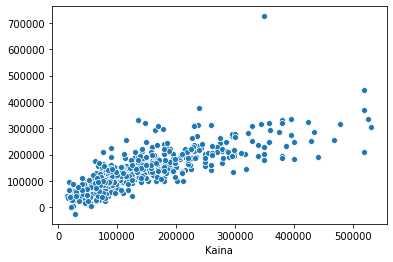

In [0]:
from sklearn.linear_model import ElasticNet
model5 = ElasticNet()

model5.fit(x_train,  y_train) 
y5_pred = model5.predict(x_test)

sns.scatterplot(y_test, y5_pred)

print('Model details:')
print('Accuracy of the model:', model5.score(x_test,y_test))
print('MAE: ', mean_absolute_error(y_test, y5_pred))
print('MedAE: ', median_absolute_error(y_test, y5_pred))
print('R^2: ', r2_score(y_test, y5_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y5_pred))

## 3.6 Modelis: XGBRegressor

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model details:
Accuracy of the model: 0.796871884270046
MAE:  25930.531833264955
MedAE:  15347.79296875
R^2:  0.796871884270046
Mean Squared Error:  1644069370.4663038


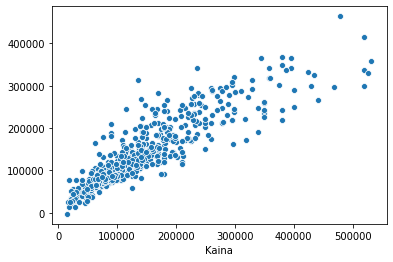

In [0]:
from xgboost import XGBRegressor

model6 = XGBRegressor()

model6.fit(x_train, y_train)
y6_pred = model6.predict(x_test)

sns.scatterplot(y_test, y6_pred)

print('Model details:')
print('Accuracy of the model:', model6.score(x_test,y_test))
print('MAE: ', mean_absolute_error(y_test, y6_pred))
print('MedAE: ', median_absolute_error(y_test, y6_pred))
print('R^2: ', r2_score(y_test, y6_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y6_pred))

## 3.7 Modelis: Lasso

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2211279917927.511, tolerance: 1660442061.441304
  positive)


Model details:
Accuracy of the model: 0.796871884270046
MAE:  29927.68967490666
MedAE:  19946.691683059325
R^2:  0.7255283256844833
Mean Squared Error:  2221506713.53961


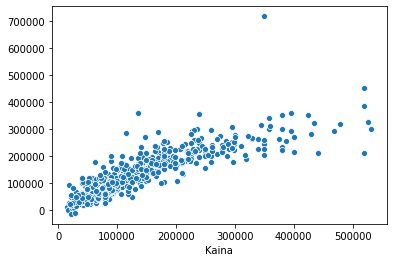

In [0]:
from sklearn.linear_model import Lasso

model7=Lasso()
model7.fit(x_train, y_train)
y7_pred = model7.predict(x_test)

sns.scatterplot(y_test, y7_pred)

print('Model details:')
print('Accuracy of the model:', model6.score(x_test,y_test))
print('MAE: ', mean_absolute_error(y_test, y7_pred))
print('MedAE: ', median_absolute_error(y_test, y7_pred))
print('R^2: ', r2_score(y_test, y7_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y7_pred))

## API modelis

Accuracy of the model: 0.8197476108367181
MAE:  12520.767997789622
MedAE:  8046.9778489238815
R^2:  0.8197476108367182
Mean Squared Error:  341778443.5052944


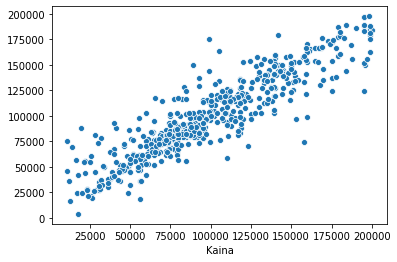

In [0]:
df_bendras_m2=df_bendras_m2.loc[df_bendras_m2['Kaina']<200000]
x3=df_bendras_m2.drop(['Kaina','Gatve'], axis=1)
y3=df_bendras_m2['Kaina']
x_train, x_test, y_train, y_test = train_test_split(x3,y3, random_state=33)

json_model=ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')
json_model.fit(x_train, y_train)
y3_pred = json_model.predict(x_test)
sns.scatterplot(y_test,y3_pred)

print('Accuracy of the model: ' + str(json_model.score(x_test,y_test)))
print('MAE: ', mean_absolute_error(y_test, y3_pred))
print('MedAE: ', median_absolute_error(y_test, y3_pred))
print('R^2: ', r2_score(y_test, y3_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y3_pred))

In [0]:
# Modelio issaugojimas .model formatu API kurimui
from sklearn.externals import joblib
joblib.dump(json_model, 'json_model.pkl')

['json_model.pkl']